In [11]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
%reload_ext autoreload

import json
from datetime import datetime
import argparse
from scipy import ndimage
import torch
import torchvision
import os
import torchvision.transforms as transforms
from collections import defaultdict, OrderedDict
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import time
import random
import yaml
import logging
import shutil
from models.resnet import NormalizeLayer, Mixed
from models.simple import reseed
from utils.utils import *
from utils.image_helper import ImageHelper
from utils.text_helper import TextHelper
logger = logging.getLogger('logger')
from prompt_toolkit import prompt
from training import *
from utils.utils import *
from IPython.display import Image
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

pilimage = ToPILImage()
import hiddenlayer as hl

from tqdm import tqdm_notebook as tqdm
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from models.smoothnet import sresnet
from data.vggface import *

In [13]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        tensor = tensor.clone()
        if tensor.dim() == 2:
            tensor.mul_(self.std[0]).add_(self.mean[0])
        else:
            for t, m, s in zip(tensor, self.mean, self.std):
                t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
unnorm = UnNormalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [14]:
path = '/media/ssd/eugene/datasets/vggface/'

In [19]:
total_list = list()
with open(path + 'train_list.txt', 'r') as f:
    for line in f.readlines():
        if '\n' in line:
            text = line[:-1]
        else:
            text = line
        img_file = 'train/'+text.strip()  # e.g. train/n004332/0317_01.jpg
        class_id = int(img_file.split("/")[1][1:])  # like n004332
        entry = (img_file, class_id,text.split('.')[0])
        total_list.append(entry)
len(total_list)

3141890

In [8]:
# test_list = list()
# with open(path + 'test_list.txt', 'r') as f:
#     for line in f.readlines():
#         if '\n' in line:
#             text = line[:-1]
#         else:
#             text = line
#         img_file = 'test/'+text.strip()  # e.g. train/n004332/0317_01.jpg
#         class_id = int(img_file.split("/")[1][1:])  # like n004332
#         entry = (img_file, class_id,text.split('.')[0])
#         test_list.append(entry)
# len(test_list)

169396

In [23]:
classes = defaultdict(list)
for _,i, name in total_list:
    classes[i].append(name)
# for _,i,_ in test_list:
#     classes[i] += 1 

In [42]:
classes_pos = sorted(classes.keys())
classes_ivert = dict()
for i, key in enumerate(classes_pos):
    classes_ivert[key] = i

In [36]:
len(classes_pos)

8631

In [25]:
classes[2].index('n000002/0008_01')

7

In [43]:
test_list = list()
train_list = list()
for entry in total_list:
    file, i, name = entry
    ident_no = len(classes[i])
    if classes[i].index(name)>= ident_no-10:
        test_list.append( (file, classes_ivert[i], name) )
    else:
        train_list.append( (file, classes_ivert[i], name) )
    
    

In [39]:
len(test_list)

80190

In [45]:
max([i for _,i,_ in test_list])

8630

In [46]:
len(train_list)//64

47743

In [17]:
len(classes.keys())

28

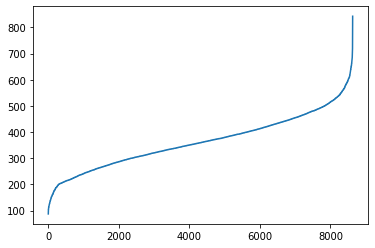

In [15]:
plt.plot(range(len(classes)), sorted([x for x in classes.values()]))
plt.show()

In [21]:
bboxes = dict()
for name in ['loose_bb_test.csv', 'loose_bb_train.csv']:
    with open(f'{path}/bb_landmark/{name}', 'r') as f:
        f.readline()
        for line in f.readlines():
            if '\n' in line:
                text = line[:-1]
            else:
                text = line
            p, x,y,w,h = text.split(',')
            p = p[1:-1]
            x = int(x)
            y = int(y)
            w = int(w)
            h = int(h)

            bboxes[p] = (x,y,w,h)

In [22]:
bboxes['n000001/0001_01']

(60, 60, 79, 109)

In [44]:
torch.save(train_list, path+'train_list.pt')
torch.save(test_list, path+'test_list.pt')
# torch.save(bboxes, path+'bboxes.pt')

3311286

In [6]:
train_ds = VGG_Faces2('/media/ssd/eugene/datasets/vggface/', train=True)

In [9]:
train_ds[92635][0].size

(135, 185)